<a href="https://colab.research.google.com/github/mabdelrehim/proteinea-challenge/blob/main/proteinea_challenge_mabdelrehim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proteinea Coding Challenge**
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mabdelrehim/proteinea-challenge/proteinea_challenge_mabdelrehim.ipynb)


In [ ]:
#### Imports

import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 1] A GAN with Linear Layers and Batch Normalization 
Here, I start running the simple GAN implementation found [here](https://github.com/amanchadha/coursera-gan-specialization/blob/main/C1%20-%20Build%20Basic%20Generative%20Adversarial%20Networks/Week%201/C1W1_Your_First_GAN.ipynb) on the MNIST dataset and make sure that training is working fine. Also, to gain some understandig of how GANs work, I skimmed the original GANs [paper](https://arxiv.org/pdf/1406.2661.pdf) 

In [ ]:
torch.manual_seed(0) # Set for testing purposes, please do not change!

## Helper Functions and Model Classes

In [ ]:
#### Helper Functions

def show_tensor_images_1(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

def get_generator_block_1(input_dim, output_dim):
    '''
    Function for returning a block of the generator's neural network
    given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a generator neural network layer, with a linear transformation 
          followed by a batch normalization and then a relu activation
    '''
    return nn.Sequential(
        # Hint: Replace all of the "None" with the appropriate dimensions.
        # The documentation may be useful if you're less familiar with PyTorch:
        # https://pytorch.org/docs/stable/nn.html.
        #### START CODE HERE ####
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
        #### END CODE HERE ####
    )


def get_noise_1(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    # NOTE: To use this on GPU with device='cuda', make sure to pass the device 
    # argument to the function you use to generate the noise.
    #### START CODE HERE ####
    return torch.randn(n_samples,z_dim,device=device)
    #### END CODE HERE ####


def get_discriminator_block_1(input_dim, output_dim):
    '''
    Discriminator Block
    Function for returning a neural network of the discriminator given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a discriminator neural network layer, with a linear transformation 
          followed by an nn.LeakyReLU activation with negative slope of 0.2 
          (https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html)
    '''
    return nn.Sequential(
        #### START CODE HERE ####
         nn.Linear(input_dim, output_dim), #Layer 1
         nn.LeakyReLU(0.2, inplace=True)
        #### END CODE HERE ####
    )



def get_disc_loss_1(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''
    #     These are the steps you will need to complete:
    #       1) Create noise vectors and generate a batch (num_images) of fake images. 
    #            Make sure to pass the device argument to the noise.
    #       2) Get the discriminator's prediction of the fake image 
    #            and calculate the loss. Don't forget to detach the generator!
    #            (Remember the loss function you set earlier -- criterion. You need a 
    #            'ground truth' tensor in order to calculate the loss. 
    #            For example, a ground truth tensor for a fake image is all zeros.)
    #       3) Get the discriminator's prediction of the real image and calculate the loss.
    #       4) Calculate the discriminator's loss by averaging the real and fake loss
    #            and set it to disc_loss.
    #     *Important*: You should NOT write your own loss function here - use criterion(pred, true)!
    #### START CODE HERE ####
    fake_noise = get_noise_1(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    #### END CODE HERE ####
    return disc_loss

def get_gen_loss_1(gen, disc, criterion, num_images, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    '''
    #     These are the steps you will need to complete:
    #       1) Create noise vectors and generate a batch of fake images. 
    #           Remember to pass the device argument to the get_noise function.
    #       2) Get the discriminator's prediction of the fake image.
    #       3) Calculate the generator's loss. Remember the generator wants
    #          the discriminator to think that its fake images are real
    #     *Important*: You should NOT write your own loss function here - use criterion(pred, true)!

    #### START CODE HERE ####
    fake_noise = get_noise_1(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    #### END CODE HERE ####
    return gen_loss



In [ ]:
#### Tests

# Verify the generator block function
def test_gen_block_1(in_features, out_features, num_test=1000):
    block = get_generator_block_1(in_features, out_features)

    # Check the three parts
    assert len(block) == 3
    assert type(block[0]) == nn.Linear
    assert type(block[1]) == nn.BatchNorm1d
    assert type(block[2]) == nn.ReLU
    
    # Check the output shape
    test_input = torch.randn(num_test, in_features)
    test_output = block(test_input)
    assert tuple(test_output.shape) == (num_test, out_features)
    assert test_output.std() > 0.55
    assert test_output.std() < 0.65

# Verify the generator class
def test_generator_1(z_dim, im_dim, hidden_dim, num_test=10000):
    gen = Generator_1(z_dim, im_dim, hidden_dim).get_gen()
    
    # Check there are six modules in the sequential part
    assert len(gen) == 6
    assert str(gen.__getitem__(4)).replace(' ', '') == f'Linear(in_features={hidden_dim * 8},out_features={im_dim},bias=True)'
    assert str(gen.__getitem__(5)).replace(' ', '') == 'Sigmoid()'
    test_input = torch.randn(num_test, z_dim)
    test_output = gen(test_input)

    # Check that the output shape is correct
    assert tuple(test_output.shape) == (num_test, im_dim)
    assert test_output.max() < 1, "Make sure to use a sigmoid"
    assert test_output.min() > 0, "Make sure to use a sigmoid"
    assert test_output.std() > 0.05, "Don't use batchnorm here"
    assert test_output.std() < 0.15, "Don't use batchnorm here"

# Verify the noise vector function
def test_get_noise_1(n_samples, z_dim, device='cpu'):
    noise = get_noise_1(n_samples, z_dim, device)
    
    # Make sure a normal distribution was used
    assert tuple(noise.shape) == (n_samples, z_dim)
    assert torch.abs(noise.std() - torch.tensor(1.0)) < 0.01
    assert str(noise.device).startswith(device)

# Verify the discriminator block function
def test_disc_block_1(in_features, out_features, num_test=10000):
    block = get_discriminator_block_1(in_features, out_features)

    # Check there are two parts
    assert len(block) == 2
    test_input = torch.randn(num_test, in_features)
    test_output = block(test_input)

    # Check that the shape is right
    assert tuple(test_output.shape) == (num_test, out_features)
    
    # Check that the LeakyReLU slope is about 0.2
    assert -test_output.min() / test_output.max() > 0.1
    assert -test_output.min() / test_output.max() < 0.3
    assert test_output.std() > 0.3
    assert test_output.std() < 0.5
    
    assert str(block.__getitem__(0)).replace(' ', '') == f'Linear(in_features={in_features},out_features={out_features},bias=True)'        
    assert str(block.__getitem__(1)).replace(' ', '').replace(',inplace=True', '') == 'LeakyReLU(negative_slope=0.2)'

# Verify the discriminator class
def test_discriminator_1(z_dim, hidden_dim, num_test=100):
    
    disc = Discriminator_1(z_dim, hidden_dim).get_disc()

    # Check there are three parts
    assert len(disc) == 4
    assert type(disc.__getitem__(3)) == nn.Linear

    # Check the linear layer is correct
    test_input = torch.randn(num_test, z_dim)
    test_output = disc(test_input)
    assert tuple(test_output.shape) == (num_test, 1)

def test_disc_reasonable_1(num_images=10):
    z_dim = 64
    gen = torch.zeros_like
    disc = nn.Identity()
    criterion = torch.mul # Multiply
    real = torch.ones(num_images, 1)
    disc_loss = get_disc_loss_1(gen, disc, criterion, real, num_images, z_dim, 'cpu')
    assert tuple(disc_loss.shape) == (num_images, z_dim)
    assert torch.all(torch.abs(disc_loss - 0.5) < 1e-5)

    gen = torch.ones_like
    disc = nn.Identity()
    criterion = torch.mul # Multiply
    real = torch.zeros(num_images, 1)
    assert torch.all(torch.abs(get_disc_loss_1(gen, disc, criterion, real, num_images, z_dim, 'cpu')) < 1e-5)

def test_disc_loss_1(max_tests = 10):
    z_dim = 64
    gen = Generator_1(z_dim).to(device)
    gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
    disc = Discriminator_1().to(device) 
    disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)
    num_steps = 0
    for real, _ in dataloader:
        cur_batch_size = len(real)
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        # Zero out the gradient before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss_1(gen, disc, criterion, real, cur_batch_size, z_dim, device)
        assert (disc_loss - 0.68).abs() < 0.05

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Check that they detached correctly
        assert gen.gen[0][0].weight.grad is None

        # Update optimizer
        old_weight = disc.disc[0][0].weight.data.clone()
        disc_opt.step()
        new_weight = disc.disc[0][0].weight.data
        
        # Check that some discriminator weights changed
        assert not torch.all(torch.eq(old_weight, new_weight))
        num_steps += 1
        if num_steps >= max_tests:
            break

def test_gen_reasonable_1(num_images=10):
    z_dim = 64
    gen = torch.zeros_like
    disc = nn.Identity()
    criterion = torch.mul # Multiply
    gen_loss_tensor = get_gen_loss_1(gen, disc, criterion, num_images, z_dim, 'cpu')
    assert torch.all(torch.abs(gen_loss_tensor) < 1e-5)
    #Verify shape. Related to gen_noise parametrization
    assert tuple(gen_loss_tensor.shape) == (num_images, z_dim)

    gen = torch.ones_like
    disc = nn.Identity()
    criterion = torch.mul # Multiply
    real = torch.zeros(num_images, 1)
    gen_loss_tensor = get_gen_loss_1(gen, disc, criterion, num_images, z_dim, 'cpu')
    assert torch.all(torch.abs(gen_loss_tensor - 1) < 1e-5)
    #Verify shape. Related to gen_noise parametrization
    assert tuple(gen_loss_tensor.shape) == (num_images, z_dim)
    

def test_gen_loss_1(num_images):
    z_dim = 64
    gen = Generator_1(z_dim).to(device)
    gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
    disc = Discriminator_1().to(device) 
    disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)
    
    gen_loss = get_gen_loss_1(gen, disc, criterion, num_images, z_dim, device)
    
    # Check that the loss is reasonable
    assert (gen_loss - 0.7).abs() < 0.1
    gen_loss.backward()
    old_weight = gen.gen[0][0].weight.clone()
    gen_opt.step()
    new_weight = gen.gen[0][0].weight
    assert not torch.all(torch.eq(old_weight, new_weight))



In [ ]:
#### Discriminator and Generator Classes
class Generator_1(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
          (MNIST images are 28 x 28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator_1, self).__init__()
        # Build the neural network
        self.gen = nn.Sequential(
            get_generator_block_1(z_dim, hidden_dim),
            get_generator_block_1(hidden_dim, hidden_dim * 2),
            get_generator_block_1(hidden_dim * 2, hidden_dim * 4),
            get_generator_block_1(hidden_dim * 4, hidden_dim * 8),
            # There is a dropdown with hints if you need them! 
            #### START CODE HERE ####
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()
            #### END CODE HERE ####
        )
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.gen(noise)
    
    # Needed for grading
    def get_gen(self):
        '''
        Returns:
            the sequential model
        '''
        return self.gen

class Discriminator_1(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
            (MNIST images are 28x28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator_1, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block_1(im_dim, hidden_dim * 4),
            get_discriminator_block_1(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block_1(hidden_dim * 2, hidden_dim),
            # Hint: You want to transform the final output into a single value,
            #       so add one more linear map.
            #### START CODE HERE ####
            nn.Linear(hidden_dim, 1)
            #### END CODE HERE ####
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        return self.disc(image)
    
    # Needed for grading
    def get_disc(self):
        '''
        Returns:
            the sequential model
        '''
        return self.disc

## Model, Dataset, and Hyperparameters



In [ ]:
# Set your parameters
criterion = nn.BCEWithLogitsLoss()

# we will use 20 epochs throughout the task
n_epochs = 20
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001
device = 'cuda'
# Load MNIST dataset as tensors
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)
gen = Generator_1(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator_1().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
#### Run Tests
test_gen_block_1(25, 12)
test_gen_block_1(15, 28)
print("Generator Block Test: Success!")

test_generator_1(5, 10, 20)
test_generator_1(20, 8, 24)
print("Generator Test: Success!")

if torch.cuda.is_available():
    test_get_noise_1(1000, 32, 'cuda')
    print("Get Noise GPU Test: Success!")
else:
    test_get_noise_1(1000, 100, 'cpu')
    print("Get Noise CPU: Success!")

test_disc_block_1(25, 12)
test_disc_block_1(15, 28)
print("Discriminator Block Test: Success!")

test_discriminator_1(5, 10)
test_discriminator_1(20, 8)
print("Discriminator Block Test: Success!")

test_disc_reasonable_1()
test_disc_loss_1()
print("Discriminator Loss Test: Success!")

test_gen_reasonable_1(10)
test_gen_loss_1(18)
print("Generator Loss Test: Success!")


Generator Block Test: Success!
Generator Test: Success!
Get Noise GPU Test: Success!
Discriminator Block Test: Success!
Discriminator Block Test: Success!
Discriminator Loss Test: Success!
Generator Loss Test: Success!


## Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 1.3865106766223894, discriminator loss: 0.4192373313307766


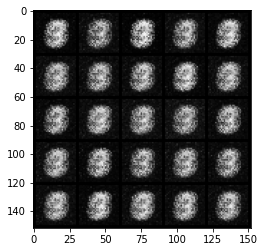

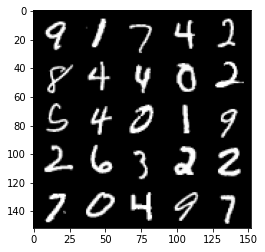

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 1.6669293873310076, discriminator loss: 0.3017136572599415


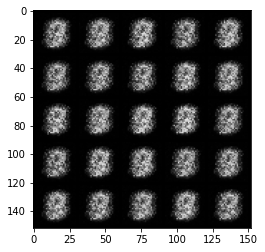

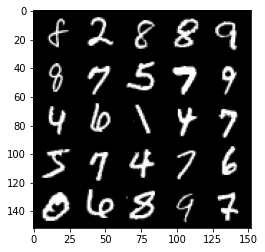

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss: 1.9487764999866466, discriminator loss: 0.17725475448369984


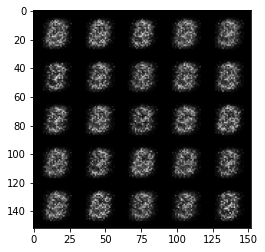

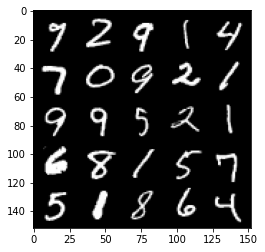

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 1.761482778787613, discriminator loss: 0.19680719634890564


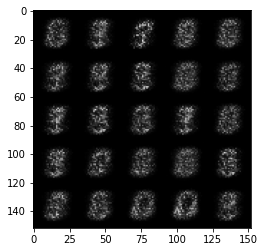

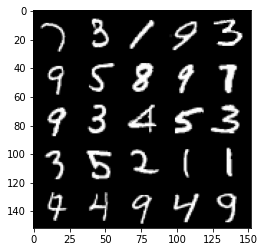

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2500: Generator loss: 1.7386042301654814, discriminator loss: 0.19267115998268133


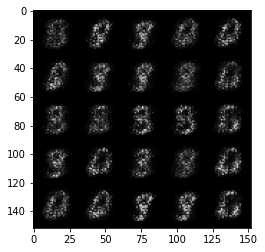

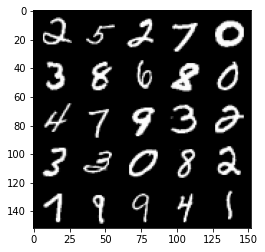

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 2.0301141438484196, discriminator loss: 0.14808698609471319


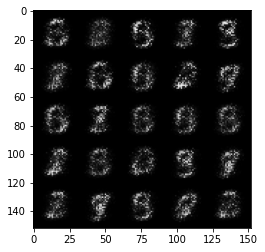

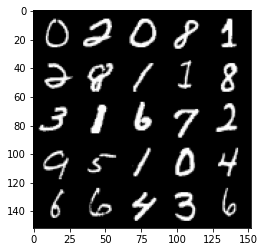

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3500: Generator loss: 2.4138925542831426, discriminator loss: 0.12621985642611985


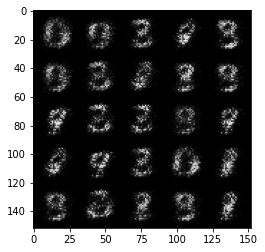

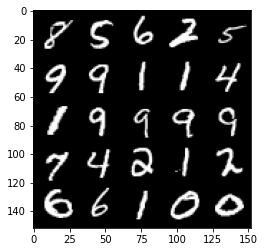

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Generator loss: 2.705683398723602, discriminator loss: 0.11934977743029594


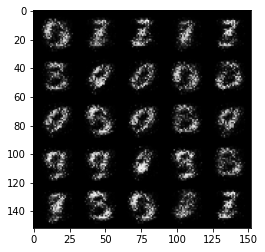

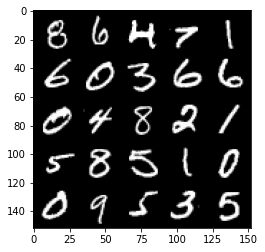

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4500: Generator loss: 3.1946048583984363, discriminator loss: 0.09662843857705598


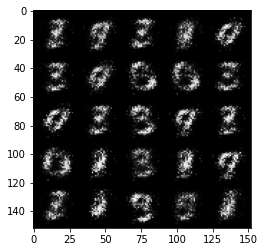

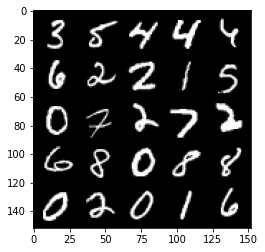

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Generator loss: 3.458129579067229, discriminator loss: 0.08168242959678174


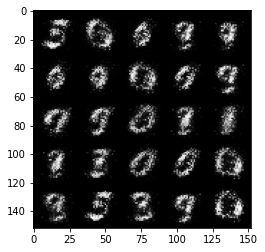

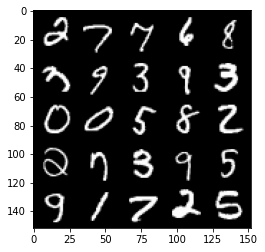

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5500: Generator loss: 3.590511153221131, discriminator loss: 0.0859992532059551


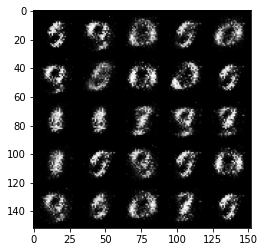

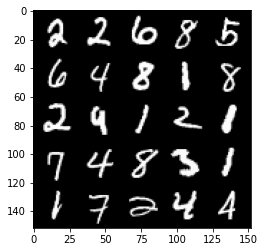

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6000: Generator loss: 3.5779493622779874, discriminator loss: 0.08481806514412166


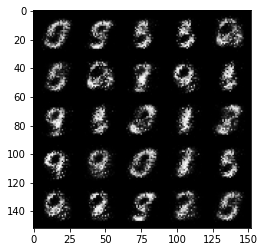

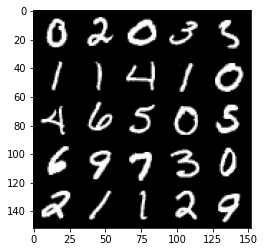

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6500: Generator loss: 3.8598757209777808, discriminator loss: 0.06517086567729713


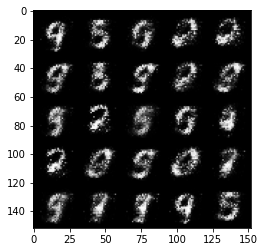

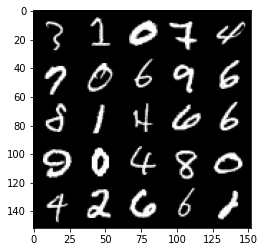

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7000: Generator loss: 4.0199344820976295, discriminator loss: 0.05163926271721724


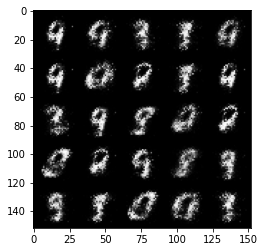

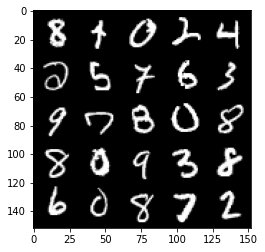

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7500: Generator loss: 4.0414046120643645, discriminator loss: 0.04858282041177154


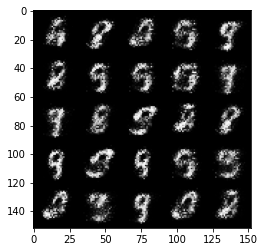

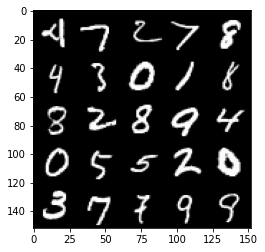

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8000: Generator loss: 4.040623122692104, discriminator loss: 0.054316141102462995


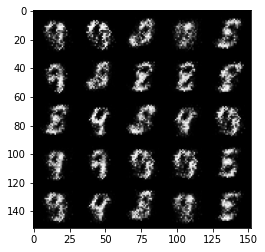

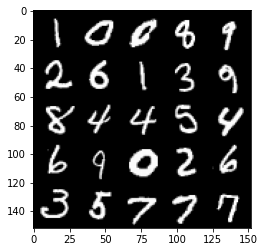

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8500: Generator loss: 4.165588750362398, discriminator loss: 0.05320291289314628


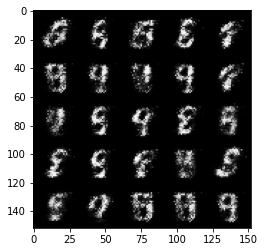

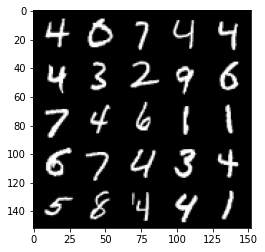

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9000: Generator loss: 4.115794569015504, discriminator loss: 0.06735611395537852


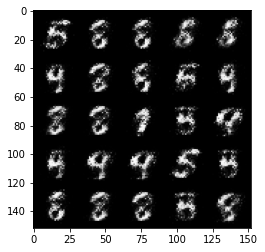

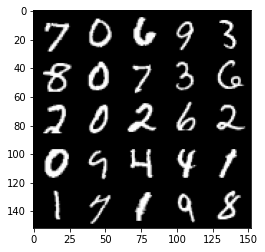

In [8]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True # Whether the generator should be tested
gen_loss = False
error = False
for epoch in range(n_epochs):
  
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        # Zero out the gradients before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss_1(gen, disc, criterion, real, cur_batch_size, z_dim, device)

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Update optimizer
        disc_opt.step()

        # For testing purposes, to keep track of the generator weights
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        ### Update generator ###
        #     Hint: This code will look a lot like the discriminator updates!
        #     These are the steps you will need to complete:
        #       1) Zero out the gradients.
        #       2) Calculate the generator loss, assigning it to gen_loss.
        #       3) Backprop through the generator: update the gradients and optimizer.
        #### START CODE HERE ####
        gen_opt.zero_grad()
        gen_loss = get_gen_loss_1(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()
        #### END CODE HERE ####

        # For testing purposes, to check that your code changes the generator weights
        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise_1(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images_1(fake)
            show_tensor_images_1(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1

# 2] A GAN with Linear Layers and NO Batch Normalization

## New Helper Functions and Model Classes

In [9]:
def get_generator_block_2(input_dim, output_dim):
    '''
    Function for returning a block of the generator's neural network
    given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a generator neural network layer, with a linear transformation 
          followed by a batch normalization and then a relu activation
    '''
    return nn.Sequential(
        # Hint: Replace all of the "None" with the appropriate dimensions.
        # The documentation may be useful if you're less familiar with PyTorch:
        # https://pytorch.org/docs/stable/nn.html.
        #### START CODE HERE ####
        nn.Linear(input_dim, output_dim),
        # nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
        #### END CODE HERE ####
    )


In [10]:
#### Discriminator and Generator Classes
class Generator_2(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
          (MNIST images are 28 x 28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator_2, self).__init__()
        # Build the neural network
        self.gen = nn.Sequential(
            get_generator_block_1(z_dim, hidden_dim),
            get_generator_block_1(hidden_dim, hidden_dim * 2),
            get_generator_block_1(hidden_dim * 2, hidden_dim * 4),
            get_generator_block_1(hidden_dim * 4, hidden_dim * 8),
            # There is a dropdown with hints if you need them! 
            #### START CODE HERE ####
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()
            #### END CODE HERE ####
        )
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.gen(noise)
    
    # Needed for grading
    def get_gen(self):
        '''
        Returns:
            the sequential model
        '''
        return self.gen

## Model, Dataset, and Hyperparameters


In [11]:
# Set your parameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 20
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001
device = 'cuda'
# Load MNIST dataset as tensors
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)
gen = Generator_2(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator_1().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

## Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 1.431771720886231, discriminator loss: 0.4209774546623228


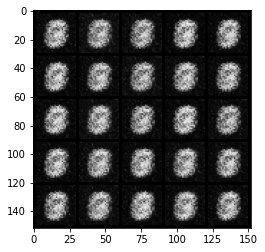

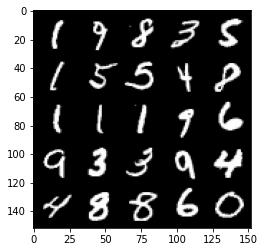

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 1.7095965909957889, discriminator loss: 0.29442868155241


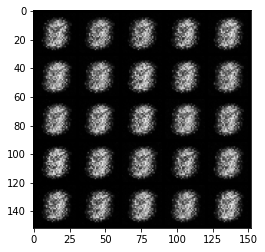

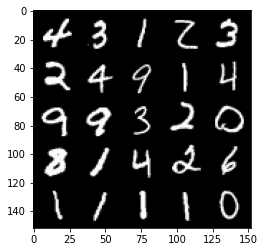

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss: 1.998955355644226, discriminator loss: 0.17293770530819888


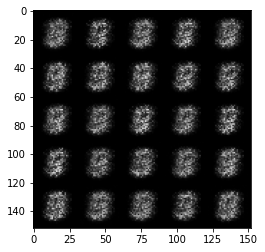

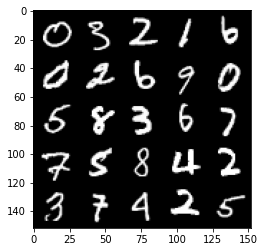

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 1.70710191988945, discriminator loss: 0.2169012657403946


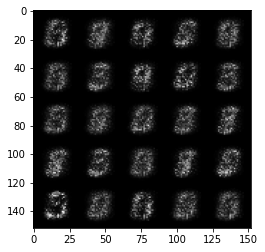

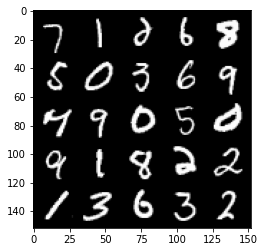

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2500: Generator loss: 1.5163342454433448, discriminator loss: 0.25646216654777526


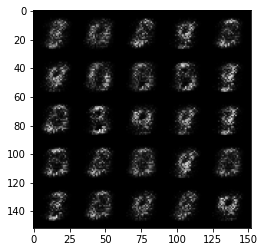

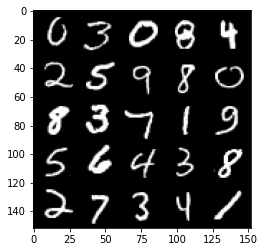

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 1.6731866796016703, discriminator loss: 0.2159967556893826


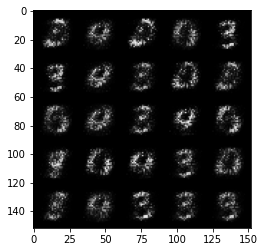

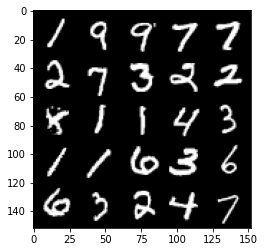

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3500: Generator loss: 2.15373455166817, discriminator loss: 0.14889269235730182


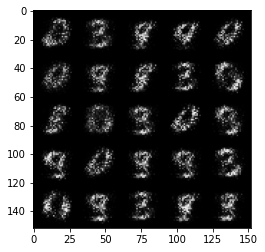

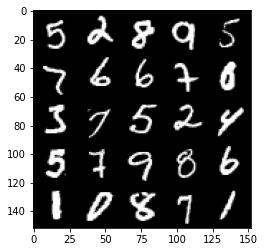

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Generator loss: 2.6680370812416045, discriminator loss: 0.10360935747623436


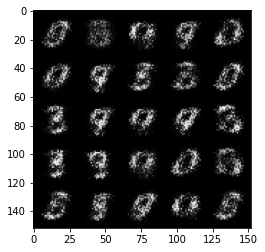

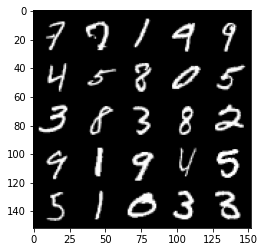

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4500: Generator loss: 2.912110783100131, discriminator loss: 0.10632217867672437


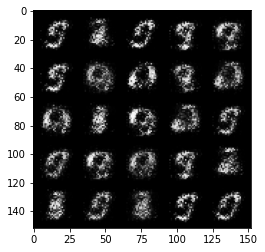

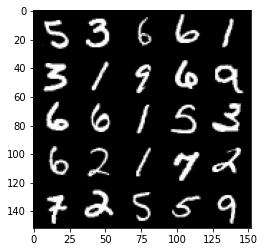

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Generator loss: 2.9616636281013506, discriminator loss: 0.12357536092400542


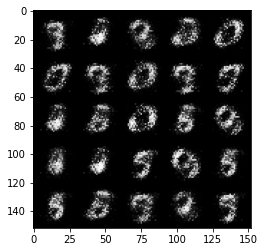

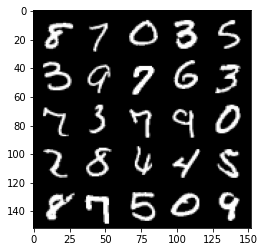

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5500: Generator loss: 3.4352658443450945, discriminator loss: 0.09651803883910186


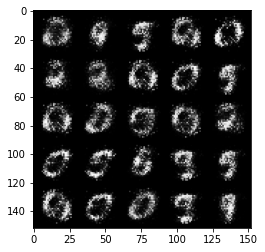

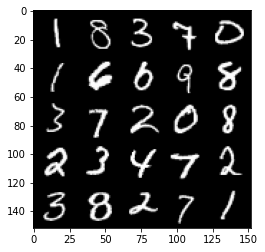

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6000: Generator loss: 3.5737835946083085, discriminator loss: 0.07219618353247645


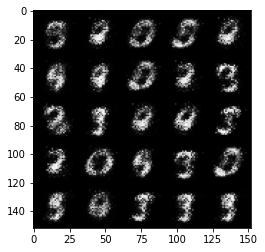

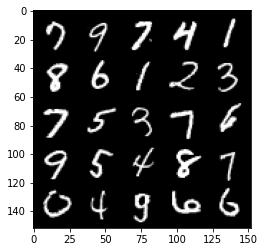

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6500: Generator loss: 3.8654028573036183, discriminator loss: 0.06236061239242555


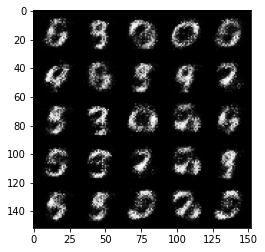

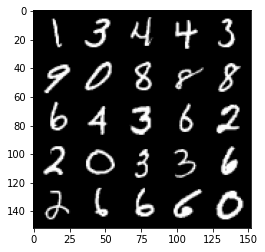

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7000: Generator loss: 3.5599844059944163, discriminator loss: 0.07040452208369967


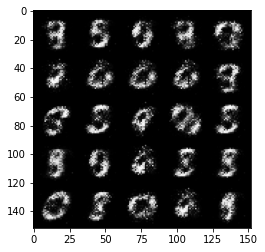

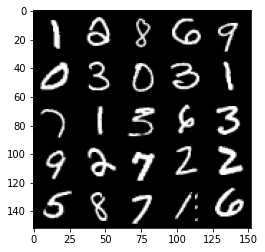

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7500: Generator loss: 3.651491691589354, discriminator loss: 0.0750138669312001


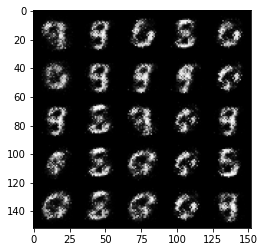

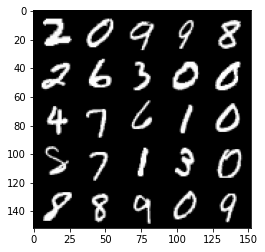

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8000: Generator loss: 3.756330255508422, discriminator loss: 0.07647054233402009


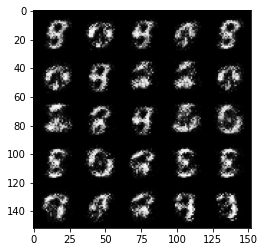

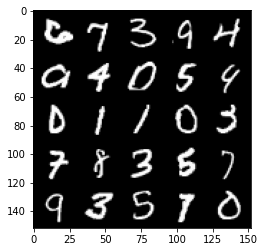

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8500: Generator loss: 3.8745419850349427, discriminator loss: 0.0720208281353116


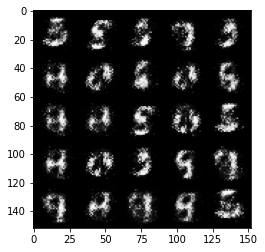

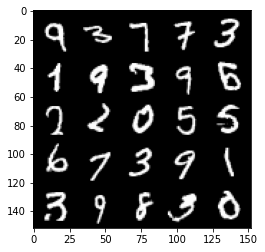

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9000: Generator loss: 3.9868856205940255, discriminator loss: 0.0680958035998046


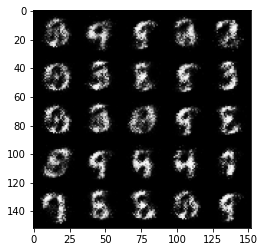

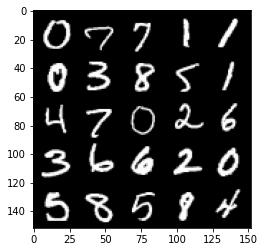

In [12]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True # Whether the generator should be tested
gen_loss = False
error = False
for epoch in range(n_epochs):
  
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        # Zero out the gradients before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss_1(gen, disc, criterion, real, cur_batch_size, z_dim, device)

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Update optimizer
        disc_opt.step()

        # For testing purposes, to keep track of the generator weights
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        ### Update generator ###
        #     Hint: This code will look a lot like the discriminator updates!
        #     These are the steps you will need to complete:
        #       1) Zero out the gradients.
        #       2) Calculate the generator loss, assigning it to gen_loss.
        #       3) Backprop through the generator: update the gradients and optimizer.
        #### START CODE HERE ####
        gen_opt.zero_grad()
        gen_loss = get_gen_loss_1(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()
        #### END CODE HERE ####

        # For testing purposes, to check that your code changes the generator weights
        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise_1(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images_1(fake)
            show_tensor_images_1(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1

### Note
The Progression of the Generator without batch normalization is not as good

# 3] A GAN with 2D CNN layers and 2D Batch Normalization.

## New Helper Functions and Model Classes

In [13]:
class Generator2D(nn.Module):
    # initializers
    def __init__(self, input_dim, num_feature_maps):

        ## Note: The number of convolutional layers and
        ## the kernel size strictly depends on the input
        ## size of the MNIST dataset since I do not use
        ## resize in data preprocessing
        super(Generator2D, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(input_dim, 
                                          num_feature_maps*4, 
                                          4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(num_feature_maps*4)
        self.deconv2 = nn.ConvTranspose2d(num_feature_maps*4, 
                                          num_feature_maps*2, 
                                          3, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(num_feature_maps*2)
        self.deconv3 = nn.ConvTranspose2d(num_feature_maps*2, 
                                          num_feature_maps, 
                                          4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(num_feature_maps)
        #self.deconv4 = nn.ConvTranspose2d(num_feature_maps*2, 
        #                                  num_feature_maps, 
        #                                  4, 2, 1, bias=False)
        #self.deconv4_bn = nn.BatchNorm2d(num_feature_maps)
        self.deconv4 = nn.ConvTranspose2d(num_feature_maps, 
                                          1, 4, 2, 1) # out channels is 1 because mnist is grey scale

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        # x = F.relu(self.deconv1(input))
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        #x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = torch.tanh(self.deconv4(x))

        return x


In [14]:
class Discriminator2D(nn.Module):
    # initializers
    def __init__(self, num_feature_maps):
        ## Note: The number of convolutional layers and
        ## the kernel size strictly depends on the input
        ## size of the MNIST dataset since I do not use
        ## resize in data preprocessing
        super(Discriminator2D, self).__init__()
        self.conv1 = nn.Conv2d(1, num_feature_maps, 
                               4, 2, 1)
        self.conv2 = nn.Conv2d(num_feature_maps, 
                               num_feature_maps*2, 
                               4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(num_feature_maps*2)
        self.conv3 = nn.Conv2d(num_feature_maps*2, 
                               num_feature_maps*4, 
                               3, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(num_feature_maps*4)
        #self.conv4 = nn.Conv2d(num_feature_maps*4, 
        #                       num_feature_maps*8, 
        #                       4, 2, 1, bias=False)
        #self.conv4_bn = nn.BatchNorm2d(num_feature_maps*8)
        self.conv4 = nn.Conv2d(num_feature_maps*4, 
                               1, 4, 1, 0)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        #x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv4(x))

        return x

In [15]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()
def get_noise_3(n_samples, z_dim, device='cuda'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    # NOTE: To use this on GPU with device='cuda', make sure to pass the device 
    # argument to the function you use to generate the noise.
    
    ## here we need a tensor to fit the input shape of ConvTranspose2D
    #### START CODE HERE ####
    return torch.randn(n_samples, z_dim, 1, 1, device=device)
    #### END CODE HERE ####

def get_disc_loss_3(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''
    #     These are the steps you will need to complete:
    #       1) Create noise vectors and generate a batch (num_images) of fake images. 
    #            Make sure to pass the device argument to the noise.
    #       2) Get the discriminator's prediction of the fake image 
    #            and calculate the loss. Don't forget to detach the generator!
    #            (Remember the loss function you set earlier -- criterion. You need a 
    #            'ground truth' tensor in order to calculate the loss. 
    #            For example, a ground truth tensor for a fake image is all zeros.)
    #       3) Get the discriminator's prediction of the real image and calculate the loss.
    #       4) Calculate the discriminator's loss by averaging the real and fake loss
    #            and set it to disc_loss.
    #     *Important*: You should NOT write your own loss function here - use criterion(pred, true)!
    #### START CODE HERE ####
    fake_noise = get_noise_3(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    #### END CODE HERE ####
    return disc_loss

def get_gen_loss_3(gen, disc, criterion, num_images, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    '''
    #     These are the steps you will need to complete:
    #       1) Create noise vectors and generate a batch of fake images. 
    #           Remember to pass the device argument to the get_noise function.
    #       2) Get the discriminator's prediction of the fake image.
    #       3) Calculate the generator's loss. Remember the generator wants
    #          the discriminator to think that its fake images are real
    #     *Important*: You should NOT write your own loss function here - use criterion(pred, true)!

    #### START CODE HERE ####
    fake_noise = get_noise_3(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    #### END CODE HERE ####
    return gen_loss

def show_tensor_images_3(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

## Model, Hyperparameters, and Dataset

In [16]:
# Set your parameters
criterion = nn.BCELoss()
n_epochs = 20
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002 # from dcgan paper
beta1 = 0.5 # from dcgan paper
num_feature_maps=128
device = 'cuda'
# Load MNIST dataset as tensors
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ])),
    batch_size=batch_size,
    shuffle=True)
gen = Generator2D(z_dim, num_feature_maps)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta1, 0.999))
disc = Discriminator2D(num_feature_maps) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta1, 0.999))

## it is important here to use the same initialization scheme as the DCGAN paper
## since it greatly affects the model performance
gen.weight_init(mean=0.0, std=0.02)
disc.weight_init(mean=0.0, std=0.02)
gen = gen.to(device)
disc = disc.to(device)
print(gen)
print(disc)

Generator2D(
  (deconv1): ConvTranspose2d(64, 512, kernel_size=(4, 4), stride=(1, 1))
  (deconv1_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (deconv2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)
Discriminator2D(
  (conv1): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (con

## Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 500: Generator loss: 4.064300947129726, discriminator loss: 0.23808079025987527


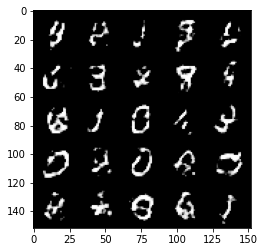

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


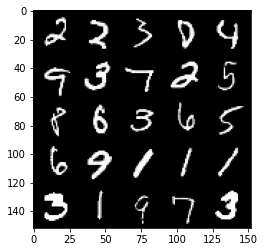

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1000: Generator loss: 2.4122523386180394, discriminator loss: 0.28310504066944087


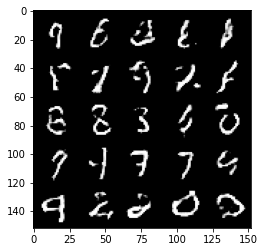

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


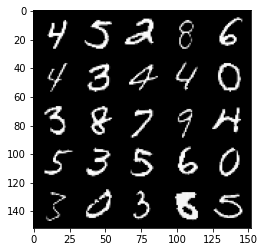

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1500: Generator loss: 2.2548365515917537, discriminator loss: 0.31587246951460873


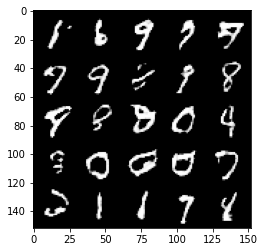

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


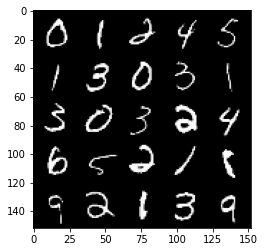

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2000: Generator loss: 2.0854498932659618, discriminator loss: 0.3442829283475872


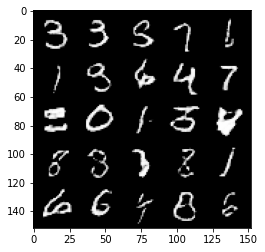

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


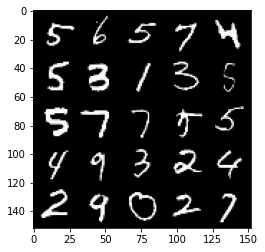

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2500: Generator loss: 2.171786301432643, discriminator loss: 0.3024376118481156


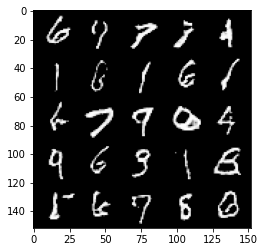

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


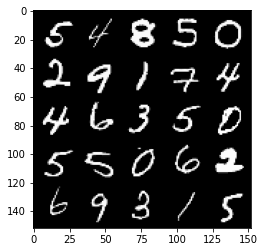

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 3000: Generator loss: 2.163568336129186, discriminator loss: 0.308735715776682


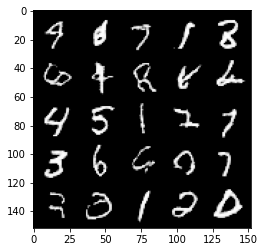

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


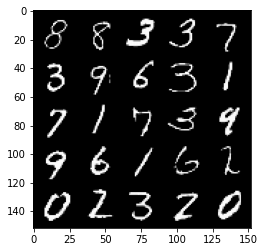

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 3500: Generator loss: 2.2365959446430215, discriminator loss: 0.3021743357032538


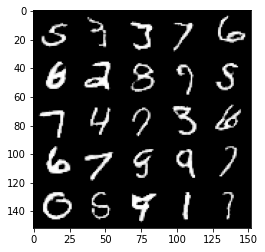

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


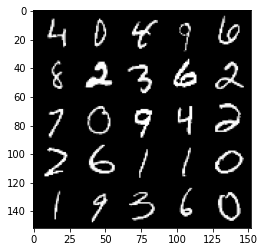

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 4000: Generator loss: 2.292441539388148, discriminator loss: 0.3027321704626084


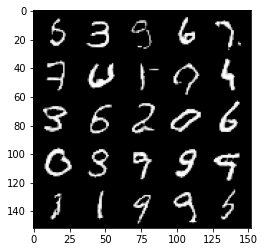

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


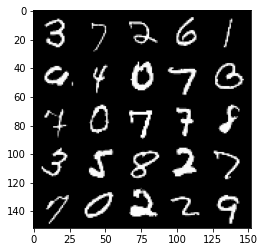

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 4500: Generator loss: 2.2995320482254025, discriminator loss: 0.2893891593217849


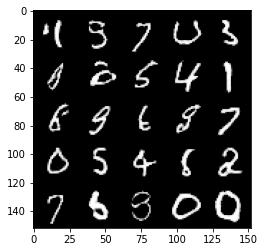

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


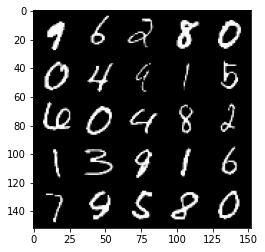

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 5000: Generator loss: 2.427276322036984, discriminator loss: 0.26443214604258547


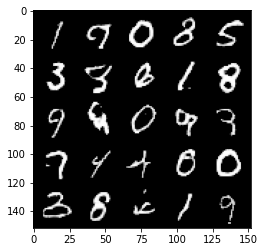

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


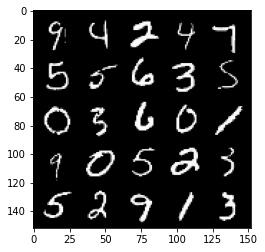

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 5500: Generator loss: 2.4303018112927686, discriminator loss: 0.25878921234607694


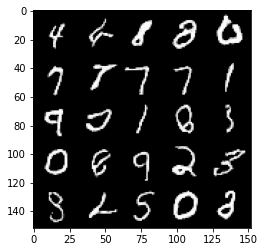

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


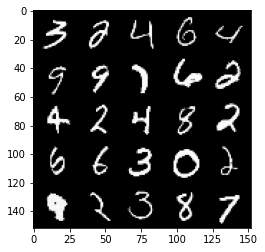

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 6000: Generator loss: 2.4007482807636267, discriminator loss: 0.26548860542476205


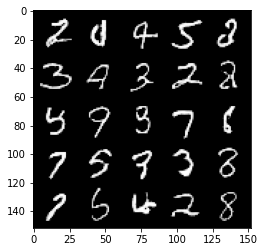

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


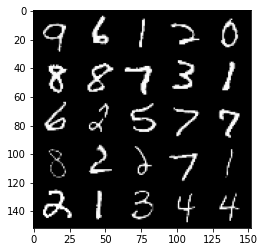

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 6500: Generator loss: 2.4966164786815637, discriminator loss: 0.24803397800028315


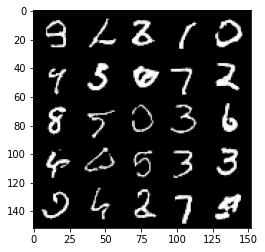

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


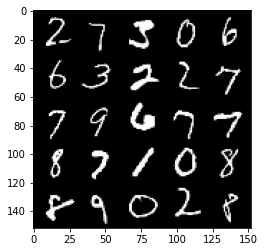

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 7000: Generator loss: 2.642189712718127, discriminator loss: 0.24131079716980444


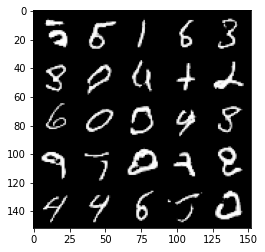

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


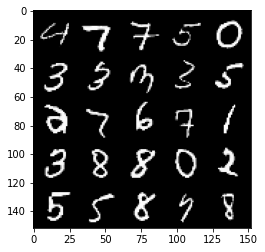

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 7500: Generator loss: 2.5520427174866214, discriminator loss: 0.2505965810567143


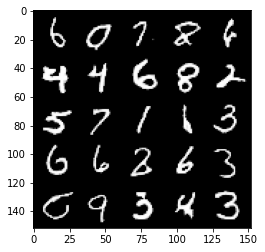

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


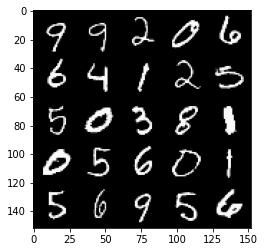

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 8000: Generator loss: 2.6758266287595034, discriminator loss: 0.21647748736292124


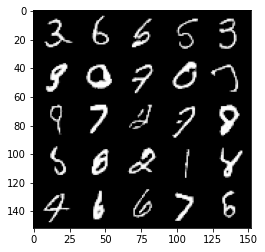

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


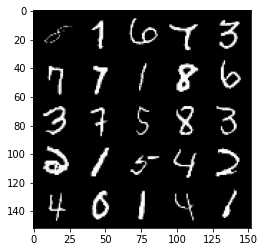

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 8500: Generator loss: 2.7957496260926122, discriminator loss: 0.21874361854046576


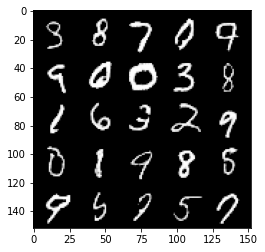

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


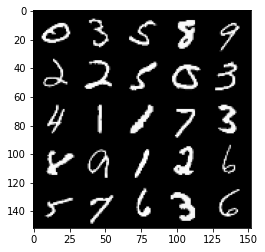

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 9000: Generator loss: 2.84796240109205, discriminator loss: 0.2165835407376291


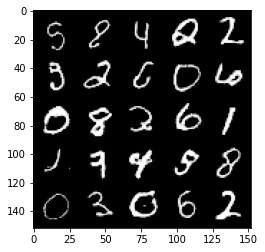

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


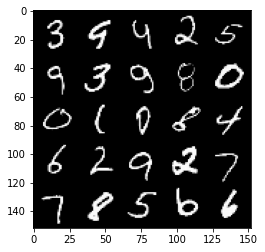

In [17]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True # Whether the generator should be tested
gen_loss = False
error = False
for epoch in range(n_epochs):
  
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        ##real = real.view(cur_batch_size, -1).to(device)
        real = real.to(device)
        ### Update discriminator ###
        # Zero out the gradients before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss_3(gen, disc, criterion, real, cur_batch_size, z_dim, device)

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Update optimizer
        disc_opt.step()

        ## For testing purposes, to keep track of the generator weights
        #if test_generator:
        #    old_generator_weights = gen.gen[0][0].weight.detach().clone()

        ### Update generator ###
        #     Hint: This code will look a lot like the discriminator updates!
        #     These are the steps you will need to complete:
        #       1) Zero out the gradients.
        #       2) Calculate the generator loss, assigning it to gen_loss.
        #       3) Backprop through the generator: update the gradients and optimizer.
        #### START CODE HERE ####
        gen_opt.zero_grad()
        gen_loss = get_gen_loss_3(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()
        #### END CODE HERE ####

        ## For testing purposes, to check that your code changes the generator weights
        #if test_generator:
        #    try:
        #        assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
        #        assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
        #    except:
        #        error = True
        #        print("Runtime tests have failed")

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise_3(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images_3(fake)
            show_tensor_images_3(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1

# 4] Spectral Normalization

Notes: The actual update of the u vector and subsequently w_bar was streightforward to implement (asside from getting the shapes right) however,
I needed to refer to the example implementation to know to update the weights 
matrix inside the conv layer. To this end I used python's getattr, hasattr, 
setattr functions

## Helper Functions and Model Classes

In [19]:
def l2normalize(v, eps=1e-12):
	return v / (v.norm() + eps)

In [20]:
class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        

    def forward(self, *args):
        
        # Initialize u
        if not hasattr(self.module, self.name + "_u"):
            # get the weight w from the module
            w = getattr(self.module, self.name)
            
            # we will do matrix the multiplication (W)^T . u
            # for that matrix multiplication to work we need 
            # the shape of u to be the first dimension of W 
            height = w.data.shape[0]
            
            # randomly initialize u as the first step of the algorithm
            u = l2normalize(w.data.new(height).normal_(0, 1))
            
            # save u in the module so we can access previous values of u
            # register buffer saves u without making it defferentiable in
            # the back-prop
            self.module.register_buffer(self.name + "_u", u)

        else:
            
            # This is the second step of the algorithm. We need to 
            # calculate W^bar_SN from u which will be used in the next 
            # SGD update
            # Power Iteration Method to approximate u and v in the
            # singular value decomposition U.S.V^T
            w = getattr(self.module, self.name)
            u = getattr(self.module, self.name + "_u")

            height = w.data.shape[0]
        
            for i in range(self.power_iterations):

                # shape of W (height x N)
                # shape of u (height x 1)
                # equations 20 & 21 in the algorithm
                v = l2normalize(
                        torch.mv(torch.t(w.view(height, -1).data), u)
                    )
                # shape of v (N x 1)


                u = l2normalize(
                        torch.mv(w.view(height, -1).data, v)
                    ) 
                # shape of u (height x 1)

                # set the attribute for the next iteration
                setattr(self.module, self.name + "_u", u)

                # approximate the spectral norm of w with u^T . W . v
                w_bar_sn = torch.dot(
                    torch.t(u), 
                    torch.mv(w.view(height, -1).data, v)
                )

                # normalize with spectral norm
                w.data = w.data / w_bar_sn

        # continue with the network
        # the back-prop will be computed on the updated w
        # from above (last step of the algorithm)    
        return self.module.forward(*args)









In [21]:
class Discriminator2DSN(nn.Module):
    # initializers
    def __init__(self, num_feature_maps):
        super(Discriminator2DSN, self).__init__()
        self.conv1 = SpectralNorm(
            nn.Conv2d(1, num_feature_maps, 
                               4, 2, 1))
        self.conv2 = SpectralNorm(
            nn.Conv2d(num_feature_maps, 
                num_feature_maps*2, 
                4, 2, 1))
        #self.conv2_bn = nn.BatchNorm2d(num_feature_maps*2)
        self.conv3 = SpectralNorm(
            nn.Conv2d(num_feature_maps*2, 
                num_feature_maps*4, 
                3, 2, 1)
            )
        #self.conv3_bn = nn.BatchNorm2d(num_feature_maps*4)
        #self.conv4 = nn.Conv2d(num_feature_maps*4, 
        #                       num_feature_maps*8, 
        #                       4, 2, 1, bias=False)
        #self.conv4_bn = nn.BatchNorm2d(num_feature_maps*8)
        self.conv4 = SpectralNorm(
            nn.Conv2d(num_feature_maps*4, 
                      1, 4, 1, 0)
            )

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        #x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv4(x))

        return x

## Model, Dataset, and Hyperparameters

In [22]:
# Set your parameters
criterion = nn.BCELoss()
n_epochs = 20
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002 # from dcgan paper
beta1 = 0.5 # from dcgan paper
num_feature_maps=128
device = 'cuda'
# Load MNIST dataset as tensors
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ])),
    batch_size=batch_size,
    shuffle=True)
gen = Generator2D(z_dim, num_feature_maps)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta1, 0.999))
disc = Discriminator2DSN(num_feature_maps) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta1, 0.999))
gen.weight_init(mean=0.0, std=0.02)
disc.weight_init(mean=0.0, std=0.02)
gen = gen.to(device)
disc = disc.to(device)
print(gen)
print(disc)

Generator2D(
  (deconv1): ConvTranspose2d(64, 512, kernel_size=(4, 4), stride=(1, 1))
  (deconv1_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (deconv2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)
Discriminator2DSN(
  (conv1): SpectralNorm(
    (module): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (conv2): SpectralNorm(
    (module): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (conv3): SpectralNorm(
    (module): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (

## Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 500: Generator loss: 1.4027787008881576, discriminator loss: 0.4406653933823106


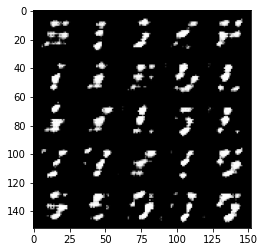

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


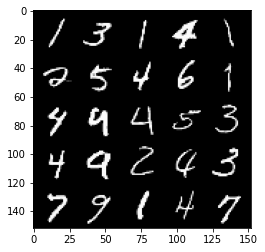

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1000: Generator loss: 1.1112482355833044, discriminator loss: 0.5406438615918159


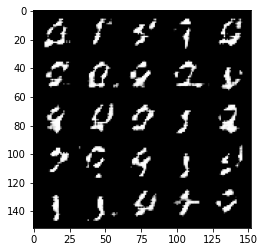

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


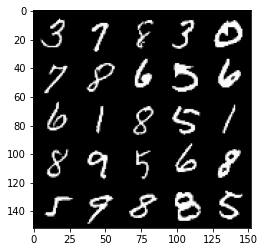

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1500: Generator loss: 0.9143011604547506, discriminator loss: 0.6117866638302808


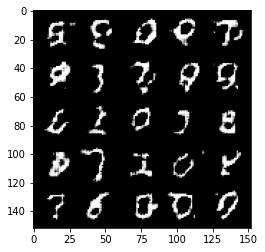

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


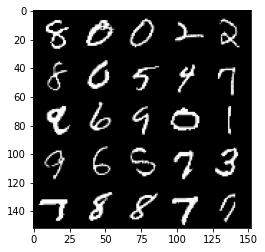

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2000: Generator loss: 0.8584285842180247, discriminator loss: 0.6350281553268432


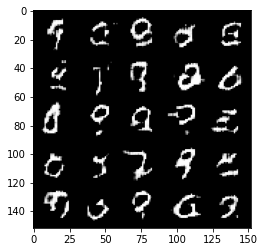

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


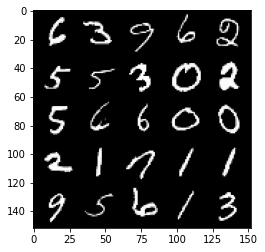

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2500: Generator loss: 0.8139008920192711, discriminator loss: 0.6504518100023271


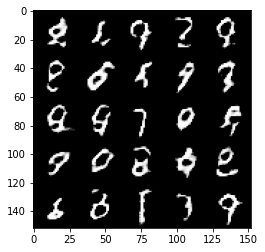

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


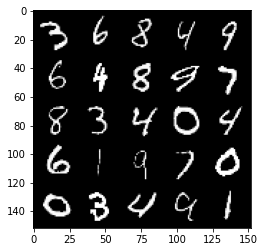

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 3000: Generator loss: 0.796530121088028, discriminator loss: 0.659595115780831


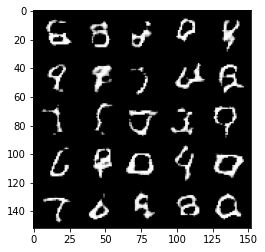

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


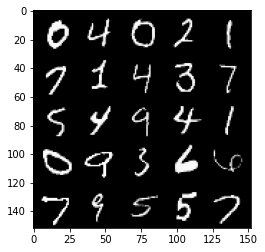

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 3500: Generator loss: 0.7772818562388423, discriminator loss: 0.6669872989654543


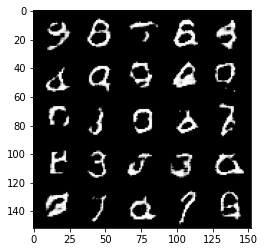

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


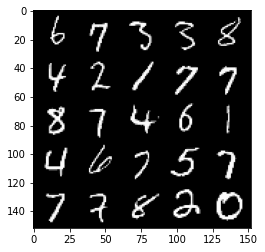

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 4000: Generator loss: 0.767782338798046, discriminator loss: 0.6723853936195376


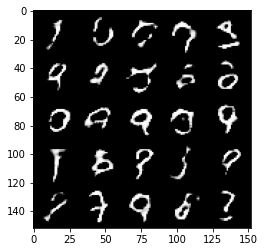

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


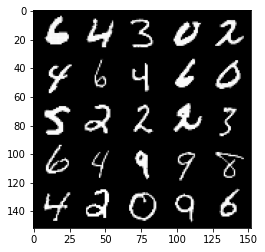

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 4500: Generator loss: 0.7614483521580696, discriminator loss: 0.674294210195541


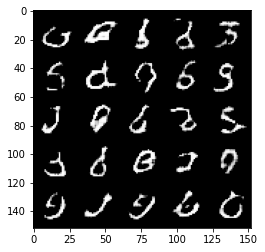

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


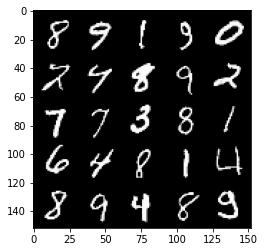

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 5000: Generator loss: 0.7526180111169818, discriminator loss: 0.6768692371845242


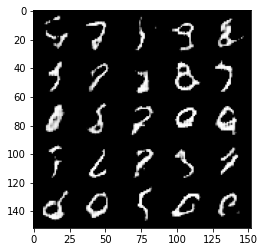

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


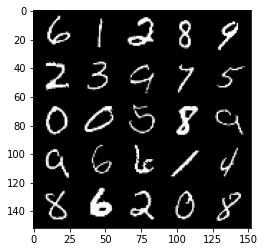

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 5500: Generator loss: 0.749638783693314, discriminator loss: 0.6792690877914431


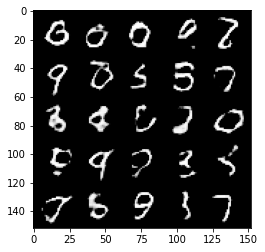

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


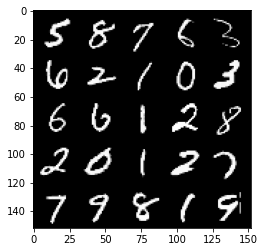

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 6000: Generator loss: 0.7459434897899632, discriminator loss: 0.680014046430587


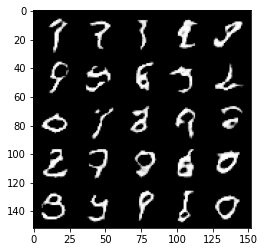

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


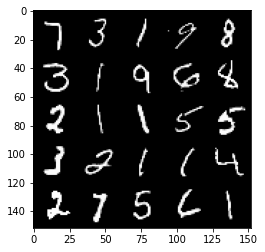

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 6500: Generator loss: 0.741231440305711, discriminator loss: 0.6816544688940055


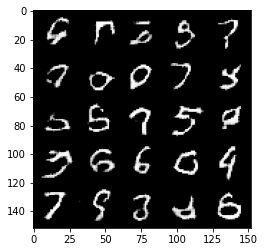

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


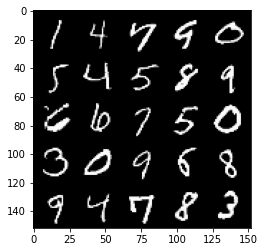

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 7000: Generator loss: 0.7389245637655253, discriminator loss: 0.6832999478578575


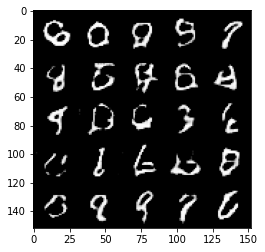

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


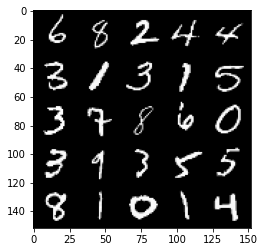

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 7500: Generator loss: 0.7356552773714067, discriminator loss: 0.6837870169878004


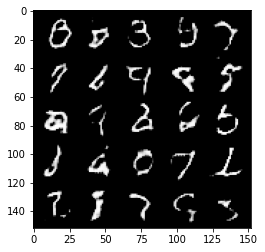

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


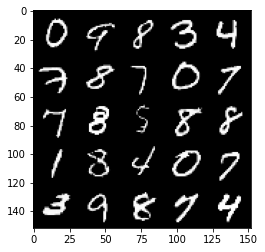

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 8000: Generator loss: 0.7324910579919821, discriminator loss: 0.6840709745883948


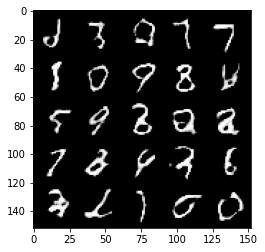

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


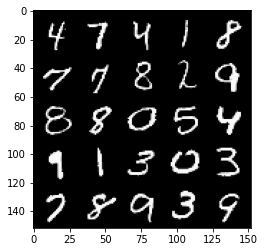

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 8500: Generator loss: 0.731463054776192, discriminator loss: 0.6850575320720671


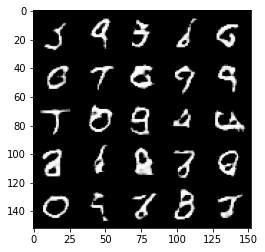

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


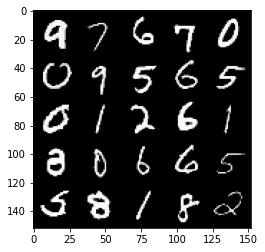

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 9000: Generator loss: 0.7222326835393911, discriminator loss: 0.6843103597164153


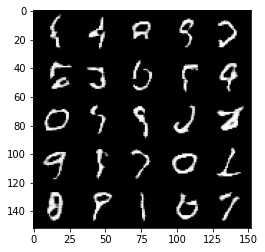

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


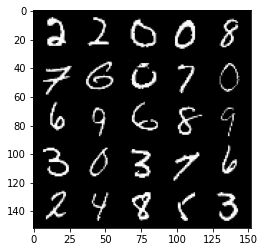

In [23]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True # Whether the generator should be tested
gen_loss = False
error = False
for epoch in range(n_epochs):
  
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        ##real = real.view(cur_batch_size, -1).to(device)
        real = real.to(device)
        ### Update discriminator ###
        # Zero out the gradients before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss_3(gen, disc, criterion, real, cur_batch_size, z_dim, device)

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Update optimizer
        disc_opt.step()

        ## For testing purposes, to keep track of the generator weights
        #if test_generator:
        #    old_generator_weights = gen.gen[0][0].weight.detach().clone()

        ### Update generator ###
        #     Hint: This code will look a lot like the discriminator updates!
        #     These are the steps you will need to complete:
        #       1) Zero out the gradients.
        #       2) Calculate the generator loss, assigning it to gen_loss.
        #       3) Backprop through the generator: update the gradients and optimizer.
        #### START CODE HERE ####
        gen_opt.zero_grad()
        gen_loss = get_gen_loss_3(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()
        #### END CODE HERE ####

        ## For testing purposes, to check that your code changes the generator weights
        #if test_generator:
        #    try:
        #        assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
        #        assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
        #    except:
        #        error = True
        #        print("Runtime tests have failed")

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise_3(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images_3(fake)
            show_tensor_images_3(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1

In [18]:
!pip freeze > requirements.txt
